In [1]:
import copy
import datetime
import warnings
warnings.filterwarnings(action='ignore') 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 시각화
import seaborn as sns
# 결측치
import missingno as msno

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import model_selection, linear_model
from sklearn.metrics import auc

# 파이프라인
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn import cluster


# 데이터 불러오기

In [2]:
data_df = pd.read_excel('milk_preprocessing_outlier.xlsx')
data_df

,Unnamed: 0,index,거주지,가입경로,담당사원,상품코드,상담횟수_y,총구매횟수_y,총구매수량_y,총구매금액_y,총할인금액_y,최종결제금액_y,할인율_y,잔여포인트_y,재구매여부,부모연령,포인트사용여부
0,0,3,인천광역시,E,전우영,89003,15,5.5,12,332100,152100,180000,46,130,0,2,0
1,1,4,경기도,H,박애신,89002,10,5.5,8,221400,101400,120000,46,96,0,1,0
2,2,6,경기도,H,박애신,35086,4,2.0,12,42000,42000,0,100,96,0,2,0
3,3,16,경기도,E,정유경,89003,6,5.5,14,442800,202800,240000,46,160,0,1,0
4,4,21,세종특별자치시,H,박애신,89002,16,10.0,8,221400,101400,120000,46,96,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19530,19530,24796,경상남도,H,이선영,35009,1,1.0,1,36900,27000,9900,73,161,0,1,0
19531,19531,24797,부산광역시,H,박애신,35008,4,2.0,7,240300,103300,137000,43,96,0,1,0
19532,19532,24798,경상북도,H,전우영,35023,1,1.0,1,14000,11000,3000,79,130,0,1,0
19533,19533,24799,경기도,E,전우영,35009,1,1.0,1,36900,27000,9900,73,130,0,1,0


In [3]:
del data_df['Unnamed: 0']
del data_df['index']

In [4]:
data_df.rename(columns={'상담횟수_y':'총상담횟수', '총구매횟수_y':'총구매횟수',\
                        '총구매수량_y':'총구매수량','총구매금액_y':'총구매금액',\
                        '총할인금액_y':'총할인금액','최종결제금액_y':'최종결제금액',\
                        '할인율_y':'할인율','잔여포인트_y':'잔여포인트'}, inplace=True)

In [5]:
#일단 한글범주형빼기
del data_df['거주지']
del data_df['담당사원']
del data_df['가입경로']

In [6]:
data_df.head()

,상품코드,총상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트,재구매여부,부모연령,포인트사용여부
0,89003,15,5.5,12,332100,152100,180000,46,130,0,2,0
1,89002,10,5.5,8,221400,101400,120000,46,96,0,1,0
2,35086,4,2.0,12,42000,42000,0,100,96,0,2,0
3,89003,6,5.5,14,442800,202800,240000,46,160,0,1,0
4,89002,16,10.0,8,221400,101400,120000,46,96,0,1,0


<AxesSubplot:>

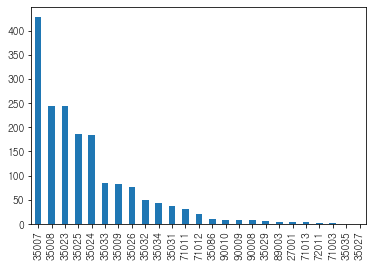

In [7]:
a = data_df[data_df['재구매여부'] == 1]
a['상품코드'].value_counts().plot(kind='bar')

In [8]:
a.count()

상품코드       1772
총상담횟수      1772
총구매횟수      1772
총구매수량      1772
총구매금액      1772
총할인금액      1772
최종결제금액     1772
할인율        1772
잔여포인트      1772
재구매여부      1772
부모연령       1772
포인트사용여부    1772
dtype: int64

In [9]:
a['부모연령'].value_counts()

1    1659
2      63
0      50
Name: 부모연령, dtype: int64

In [10]:
data_df['재구매여부'].value_counts()

0    17763
1     1772
Name: 재구매여부, dtype: int64

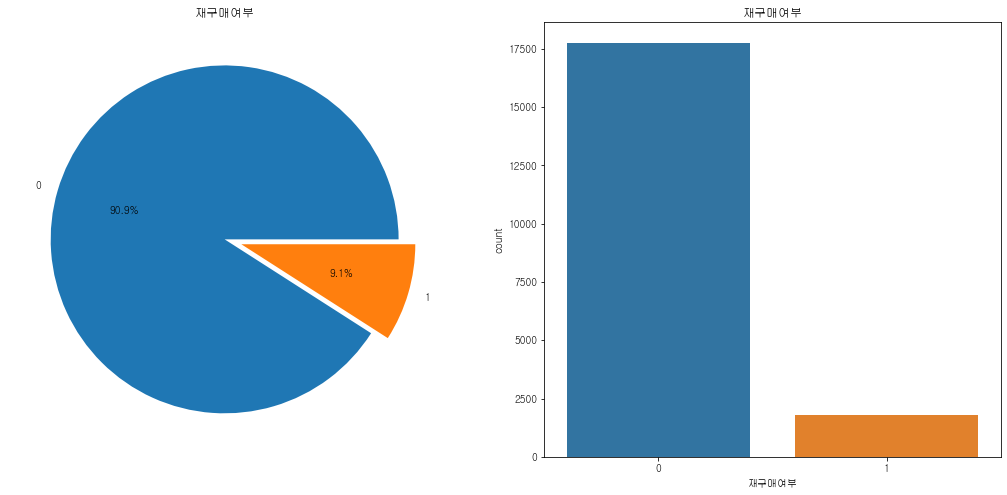

In [11]:
# 전처리와 이상치 제거 후 데이터가 줄어듬에 따라 클래스 비율이 더 극대화되었다.
f, ax = plt.subplots(1,2,figsize=(18,8))
data_df['재구매여부'].value_counts()\
.plot.pie(explode = [0,0.1], autopct = '%1.1f%%', ax=ax[0])

ax[0].set_title('재구매여부')
ax[0].set_ylabel('')

sns.countplot('재구매여부', data = data_df, ax = ax[1])
ax[1].set_title('재구매여부')
plt.show()

# 학습데이터와 타겟데이터 분리

In [12]:
data_df_temp = data_df.copy()

In [13]:
y_data=data_df_temp[["재구매여부"]].copy()
x_data=data_df_temp.copy()
del x_data["재구매여부"]

In [14]:
x_data

,상품코드,총상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트,부모연령,포인트사용여부
0,89003,15,5.5,12,332100,152100,180000,46,130,2,0
1,89002,10,5.5,8,221400,101400,120000,46,96,1,0
2,35086,4,2.0,12,42000,42000,0,100,96,2,0
3,89003,6,5.5,14,442800,202800,240000,46,160,1,0
4,89002,16,10.0,8,221400,101400,120000,46,96,1,0
...,...,...,...,...,...,...,...,...,...,...,...
19530,35009,1,1.0,1,36900,27000,9900,73,161,1,0
19531,35008,4,2.0,7,240300,103300,137000,43,96,1,0
19532,35023,1,1.0,1,14000,11000,3000,79,130,1,0
19533,35009,1,1.0,1,36900,27000,9900,73,130,1,0


# Train - Test split (비율 7:3 , seed는 0을 적용)

In [15]:
x_train, x_test, y_train, y_test =\
model_selection.train_test_split(x_data, y_data, test_size=0.3, random_state=0)

In [16]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(13674, 11)
(5861, 11)
(13674, 1)
(5861, 1)


# Train the model

In [17]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score

# 앙상블 기본 모델 학습 및 정확도 측정

In [18]:
clf_RFC = ensemble.RandomForestClassifier()
clf_RFC.fit(x_train, y_train)
acc = accuracy_score(y_test, clf_RFC.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9335


In [19]:
clf_DTC = sklearn.tree.DecisionTreeClassifier(random_state=0)
clf_DTC.fit(x_train, y_train)
acc = accuracy_score(y_test, clf_DTC.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9285


# 부스팅 알고리즘 학습 및 정확도 측정

In [20]:
from xgboost import XGBClassifier

In [21]:
clf_XGB = XGBClassifier(random_state=0)
clf_XGB.fit(x_train, y_train)
acc = accuracy_score(y_test, clf_XGB.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9374


In [22]:
clf_GB = ensemble.GradientBoostingClassifier()
clf_GB.fit(x_train, y_train)
acc = accuracy_score(y_test, clf_GB.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9307


In [23]:
# x_data.to_excel("./x_data.xlsx")
# y_data.to_excel("./y_data.xlsx")

In [24]:
from sklearn.metrics import classification_report

predictions = clf_XGB.predict(x_test)
print(classification_report(y_test, predictions)) # Precision, Recall, F1-score 등을 확인할 수 있습니다.

print("Accuracy on Training set: {:.3f}".format(clf_XGB.score(x_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(clf_XGB.score(x_test, y_test)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5359
           1       0.64      0.62      0.63       502

    accuracy                           0.94      5861
   macro avg       0.80      0.79      0.80      5861
weighted avg       0.94      0.94      0.94      5861

Accuracy on Training set: 0.968
Accuracy on Test set: 0.937


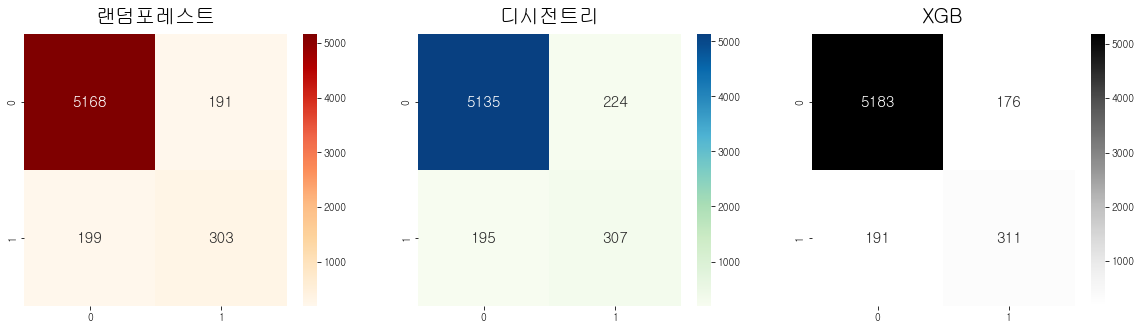

In [25]:
# confusion matrix
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 5))

confu = confusion_matrix(y_true = y_test, y_pred = clf_RFC.predict(x_test))
confu2 = confusion_matrix(y_true = y_test, y_pred = clf_DTC.predict(x_test))
confu3 = confusion_matrix(y_true = y_test, y_pred = clf_XGB.predict(x_test))


sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g', ax=ax[0])
sns.heatmap(confu2, annot=True, annot_kws={'size':15}, cmap='GnBu', fmt='.10g', ax=ax[1])
sns.heatmap(confu3, annot=True, annot_kws={'size':15}, cmap='Greys', fmt='.10g', ax=ax[2])
ax[0].set_title('랜덤포레스트',pad = 12, fontsize = 20)
ax[1].set_title('디시전트리',pad = 12, fontsize = 20)
ax[2].set_title('XGB',pad = 12, fontsize = 20)
plt.show()

# 클래스 불균형 문제 해결(오버샘플링 SMOTE)

In [26]:
from imblearn.over_sampling import SMOTE

In [27]:
smote = SMOTE(random_state=42)
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", x_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', x_train_over.shape, y_train_over.shape)
# print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", x_test.shape, y_test.shape)
print('SMOTE 적용 후 값의 분포 :\n', y_train_over.value_counts() )
#print('SMOTE 적용 후 값의 분포 :\n', y_train.value_counts() )

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (13674, 11) (13674, 1)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (24808, 11) (24808, 1)
SMOTE 적용 후 값의 분포 :
 재구매여부
0        12404
1        12404
dtype: int64


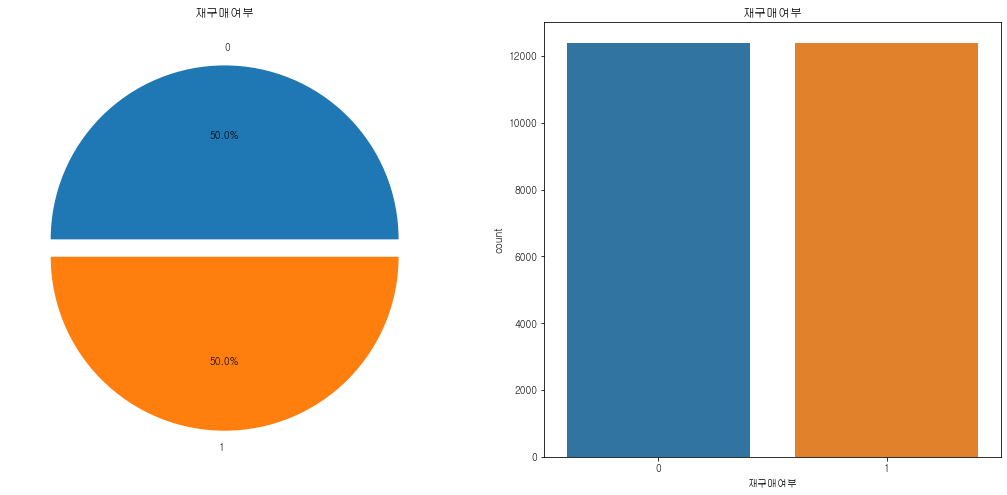

In [28]:
f, ax = plt.subplots(1,2,figsize=(18,8))
y_train_over['재구매여부'].value_counts()\
.plot.pie(explode = [0,0.1], autopct = '%1.1f%%', ax=ax[0])

ax[0].set_title('재구매여부')
ax[0].set_ylabel('')

sns.countplot('재구매여부', data = y_train_over, ax = ax[1])
ax[1].set_title('재구매여부')
plt.show()

In [29]:
y_train_over['재구매여부'].value_counts()

0    12404
1    12404
Name: 재구매여부, dtype: int64

# 재학습

In [30]:
x_train_resample, x_test, y_train_resample, y_test =\
model_selection.train_test_split(x_train_over, y_train_over, test_size=0.3, random_state=0)

In [56]:
x_train_resample

,상품코드,총상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트,부모연령,포인트사용여부
23379,35009,11,4.0,7,258300,133300,125000,52,96,1,0
8308,35009,12,4.0,4,147600,82600,65000,56,96,1,0
1919,35023,3,1.0,1,14000,11000,3000,79,96,1,0
1243,35007,3,5.5,1,18900,13900,5000,74,130,1,0
15889,35025,9,9.0,19,351900,81900,270000,23,96,1,0
...,...,...,...,...,...,...,...,...,...,...,...
13123,35023,2,1.0,1,14000,11000,3000,79,160,1,0
19648,35007,4,4.0,7,240300,115300,125000,48,152,1,0
9845,35007,2,5.5,2,37800,27800,10000,74,0,2,0
10799,35007,3,5.5,1,18900,15900,3000,84,71,1,0


In [61]:
독립 = x_train_resample[['총상담횟수','총구매횟수','총구매수량','총구매금액','총할인금액','최종결제금액']]
종속 = y_train_resample[['재구매여부']]

In [62]:
clf_RFC_re = ensemble.RandomForestClassifier()
model = clf_RFC_re.fit(독립,종속)

In [73]:
model.predict([[3,1.0,1,14000,11000,3000]])

array([0], dtype=int64)

In [72]:
종속

,재구매여부
23379,1
8308,1
1919,0
1243,0
15889,1
...,...
13123,0
19648,1
9845,0
10799,0


In [31]:
# params = {'n_estimators': 1000,
#           'max_depth': 5,
#           'min_samples_split': 7,
# #           'learning_rate': 0.01,
#          'random_state':0}

In [32]:
clf_Bagging_re = ensemble.BaggingClassifier()
clf_Bagging_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_Bagging_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9524


In [33]:
clf_RFC_re = ensemble.RandomForestClassifier()
clf_RFC_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_RFC_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9578


In [34]:
clf_DTC_re = sklearn.tree.DecisionTreeClassifier(random_state=0)
clf_DTC_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_DTC_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9459


In [35]:
clf_XGB_re = XGBClassifier(random_state=0)
clf_XGB_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_XGB_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9629


In [36]:
clf_GB_re = ensemble.GradientBoostingClassifier()
clf_GB_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_GB_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9453


In [37]:
x_train_resample

,상품코드,총상담횟수,총구매횟수,총구매수량,총구매금액,총할인금액,최종결제금액,할인율,잔여포인트,부모연령,포인트사용여부
23379,35009,11,4.0,7,258300,133300,125000,52,96,1,0
8308,35009,12,4.0,4,147600,82600,65000,56,96,1,0
1919,35023,3,1.0,1,14000,11000,3000,79,96,1,0
1243,35007,3,5.5,1,18900,13900,5000,74,130,1,0
15889,35025,9,9.0,19,351900,81900,270000,23,96,1,0
...,...,...,...,...,...,...,...,...,...,...,...
13123,35023,2,1.0,1,14000,11000,3000,79,160,1,0
19648,35007,4,4.0,7,240300,115300,125000,48,152,1,0
9845,35007,2,5.5,2,37800,27800,10000,74,0,2,0
10799,35007,3,5.5,1,18900,15900,3000,84,71,1,0


In [38]:
clf_XGB_re.predict(x_train_resample)

array([1, 1, 0, ..., 0, 0, 0])

In [54]:
print(x_train_resample.shape)
print(y_train_resample.shape)

(17365, 11)
(17365, 1)


In [39]:
x_train_resample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17365 entries, 23379 to 2732
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   상품코드     17365 non-null  int64  
 1   총상담횟수    17365 non-null  int64  
 2   총구매횟수    17365 non-null  float64
 3   총구매수량    17365 non-null  int64  
 4   총구매금액    17365 non-null  int64  
 5   총할인금액    17365 non-null  int64  
 6   최종결제금액   17365 non-null  int64  
 7   할인율      17365 non-null  int64  
 8   잔여포인트    17365 non-null  int64  
 9   부모연령     17365 non-null  int64  
 10  포인트사용여부  17365 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 1.6 MB


In [41]:
# clf_XGB_re = XGBClassifier(
#                 colsample_bytree = 0.8,\
#                 gamma = 0.8,\
#                 learning_rate = 0.05,\
#                 max_depth = 25,\
#                 min_child_weight = 0.5,\
#                 n_estimators = 200,\
#                 nthread = -1,\
#                 objective = 'binary:logistic',\
#                 scale_pos_weight = 1,\
#                 seed = 2019,\
#                 subsample = 0.8)
# clf_XGB_re.fit(x_train_resample, y_train_resample)
# acc = accuracy_score(y_test, clf_XGB_re.predict(x_test))
# print("The accuracy score on test set: {:.4f}".format(acc))

In [42]:
# clf_XGB_re = XGBClassifier(
#                 colsample_bytree = 0.8,\
#                 gamma = 0,\
#                 learning_rate = 0.05,\
#                 max_depth = 25,\
#                 min_child_weight = 0.5,\
#                 n_estimators = 200,\
#                 nthread = -1,\
#                 objective = 'binary:logistic',\
#                 scale_pos_weight = 1,\
#                 seed = 2019,\
#                 subsample = 0.8)
# clf_XGB_re.fit(x_train_resample, y_train_resample)
# acc = accuracy_score(y_test, clf_XGB_re.predict(x_test))
# print("The accuracy score on test set: {:.4f}".format(acc))

In [43]:
predictions = clf_RFC_re.predict(x_test)
print(classification_report(y_test, predictions)) # Precision, Recall, F1-score 등을 확인할 수 있습니다.

print("Accuracy on Training set: {:.3f}".format(clf_RFC_re.score(x_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(clf_RFC_re.score(x_test, y_test)))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      3732
           1       0.94      0.98      0.96      3711

    accuracy                           0.96      7443
   macro avg       0.96      0.96      0.96      7443
weighted avg       0.96      0.96      0.96      7443

Accuracy on Training set: 0.965
Accuracy on Test set: 0.958


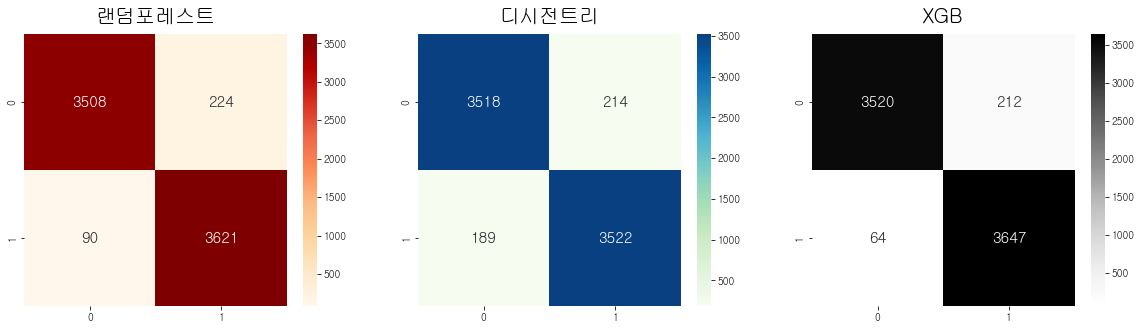

In [44]:
# confusion matrix
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 5))

confu = confusion_matrix(y_true = y_test, y_pred = clf_RFC_re.predict(x_test))
confu2 = confusion_matrix(y_true = y_test, y_pred = clf_DTC_re.predict(x_test))
confu3 = confusion_matrix(y_true = y_test, y_pred = clf_XGB_re.predict(x_test))


sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g', ax=ax[0])
sns.heatmap(confu2, annot=True, annot_kws={'size':15}, cmap='GnBu', fmt='.10g', ax=ax[1])
sns.heatmap(confu3, annot=True, annot_kws={'size':15}, cmap='Greys', fmt='.10g', ax=ax[2])
ax[0].set_title('랜덤포레스트',pad = 12, fontsize = 20)
ax[1].set_title('디시전트리',pad = 12, fontsize = 20)
ax[2].set_title('XGB',pad = 12, fontsize = 20)
plt.show()

In [45]:
# import seaborn as sns

# feature_importance_values = clf_DTC_re.feature_importances_
# # Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
# feature_importances = pd.Series(feature_importance_values, index=x_train.columns)
# # 중요도값 순으로 Series를 정렬
# feature_top5 = feature_importances.sort_values(ascending=False)[:30]

# plt.figure(figsize=[8, 6])
# plt.title('DTC Feature Importances')
# sns.barplot(x=feature_top5, y=feature_top5.index)
# plt.show()

In [46]:
# import seaborn as sns

# feature_importance_values = clf_RFC_re.feature_importances_
# # Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
# feature_importances = pd.Series(feature_importance_values, index=x_train.columns)
# # 중요도값 순으로 Series를 정렬
# feature_top5 = feature_importances.sort_values(ascending=False)[:30]

# plt.figure(figsize=[8, 6])
# plt.title('RF Feature Importances')
# sns.barplot(x=feature_top5, y=feature_top5.index)
# plt.show()

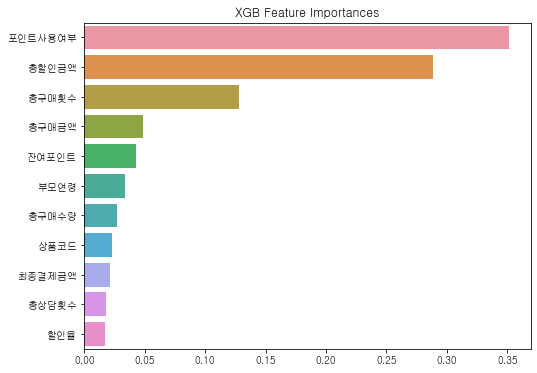

In [47]:
import seaborn as sns

feature_importance_values = clf_XGB_re.feature_importances_
# Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
feature_importances = pd.Series(feature_importance_values, index=x_train.columns)
# 중요도값 순으로 Series를 정렬
feature_top5 = feature_importances.sort_values(ascending=False)[:30]

plt.figure(figsize=[8, 6])
plt.title('XGB Feature Importances')
sns.barplot(x=feature_top5, y=feature_top5.index)
plt.show()

In [48]:
feature_top5

포인트사용여부    0.351675
총할인금액      0.288715
총구매횟수      0.128131
총구매금액      0.048401
잔여포인트      0.042856
부모연령       0.033370
총구매수량      0.026875
상품코드       0.022637
최종결제금액     0.021495
총상담횟수      0.018313
할인율        0.017532
dtype: float32

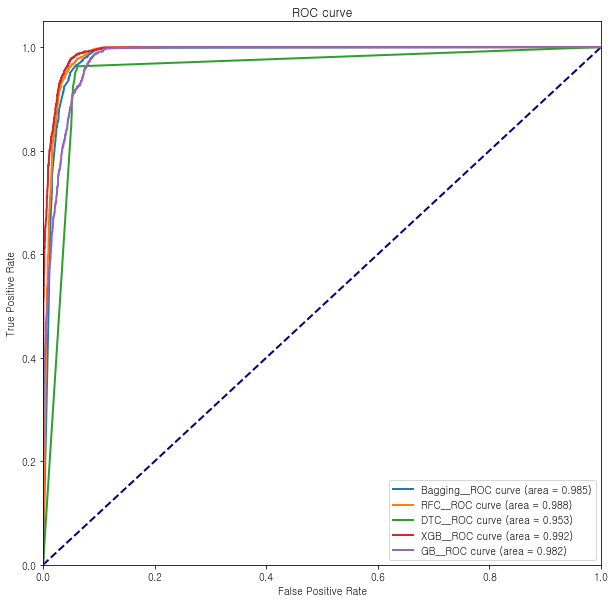

In [49]:
from sklearn.metrics import roc_curve, auc

models=['Bagging', 'RFC', 'DTC', 'XGB', 'GB']


plt.figure(figsize=(10, 10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC curve")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


for i in models:

    globals()['clf_{}_re_pred'.format(i)] = \
    globals()['clf_{}_re'.format(i)].predict_proba(x_test)
    
    globals()['clf_{}_re_roc'.format(i)]=\
    globals()['clf_{}_re_pred'.format(i)][:,1]
   
    globals()['fpr_{}_re'.format(i)],\
    globals()['tpr_{}_re'.format(i)], \
    globals()['_{}'.format(i)] \
    =roc_curve(y_true=y_test, y_score=globals()['clf_{}_re_roc'.format(i)]) 
    
    globals()['roc_auc_{}_re'.format(i)] = \
    auc(globals()['fpr_{}_re'.format(i)], globals()['tpr_{}_re'.format(i)])

    
    plt.plot(globals()['fpr_{}_re'.format(i)], globals()['tpr_{}_re'.format(i)]
             , lw=2, label=i+'__ROC curve (area = %0.3f)' %globals()['roc_auc_{}_re'.format(i)])

plt.legend()
plt.show()

In [50]:
# from sklearn.metrics import roc_curve, auc

# models=['RFC', 'DTC', 'XGB']


# plt.figure(figsize=(10, 10))
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')

# plt.title("ROC curve")
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


# for i in models:

#     globals()['clf_{}_re_pred'.format(i)] = \
#     globals()['clf_{}_re'.format(i)].predict_proba(x_test)
    
#     globals()['clf_{}_re_roc'.format(i)]=\
#     globals()['clf_{}_re_pred'.format(i)][:,1]
   
#     globals()['fpr_{}_re'.format(i)],\
#     globals()['tpr_{}_re'.format(i)], \
#     globals()['_{}'.format(i)] \
#     =roc_curve(y_true=y_test, y_score=globals()['clf_{}_re_roc'.format(i)]) 
    
#     globals()['roc_auc_{}_re'.format(i)] = \
#     auc(globals()['fpr_{}_re'.format(i)], globals()['tpr_{}_re'.format(i)])

    
#     plt.plot(globals()['fpr_{}_re'.format(i)], globals()['tpr_{}_re'.format(i)]
#              , lw=2, label=i+'__ROC curve (area = %0.3f)' %globals()['roc_auc_{}_re'.format(i)])

# plt.legend()
# plt.show()

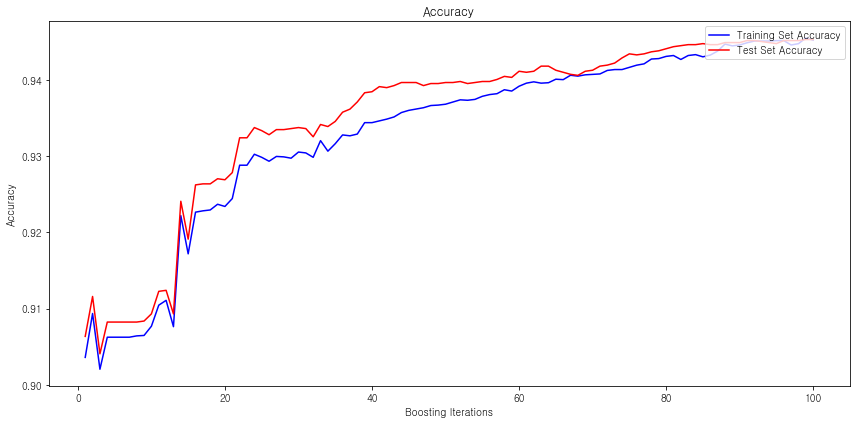

In [51]:
train_score = np.zeros((clf_GB_re.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf_GB_re.staged_predict(x_train_resample)):
    train_score[i] = accuracy_score(y_train_resample, y_pred)

test_score = np.zeros((clf_GB_re.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf_GB_re.staged_predict(x_test)):
    test_score[i] = accuracy_score(y_test, y_pred)
    
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.title('Accuracy') 
plt.plot(np.arange(clf_GB_re.n_estimators) + 1, train_score, 'b-', label='Training Set Accuracy')
plt.plot(np.arange(clf_GB_re.n_estimators) + 1, test_score, 'r-', label='Test Set Accuracy')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
fig.tight_layout()
plt.show()